In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from DE_analysis_utils import *

In [57]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 150  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 150

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'

In [33]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T

In [34]:
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim.std(1).fillna(10000)

adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

In [36]:
# Exclude from analysis genes with very low base mean across conditions
gs_mask = (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1) & (adata_de.var['mean_baseMean_Rest'] > 0.1) 
adata_de = adata_de[:, gs_mask].copy()

In [52]:
DE_results = get_DE_results_long(
        adata_de,
        targets=['GATA3'], 
        effect_estimates = ['log_fc', 'lfcSE'],
        signif_estimate = 'adj_p_value',
        target_id_col = 'target_contrast_gene_name',
        gene_id_col='gene_ids'
    )

In [77]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = calculate_reliability(x_a, sigma_a)
    rel_b = calculate_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)


In [ ]:
DE_results_1 = DE_results[DE_results['culture_condition'] == 'Rest'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()
DE_results_2 = DE_results[DE_results['culture_condition'] == 'Stim8hr'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()

# Filter for significant effects first
DE_results_1 = DE_results_1[DE_results_1['adj_p_value'] < 0.1]
DE_results_2 = DE_results_2[DE_results_2['adj_p_value'] < 0.1]

# Get common significant genes
common_genes = DE_results_1.index.intersection(DE_results_2.index)
DE_results_1 = DE_results_1.loc[common_genes]
DE_results_2 = DE_results_2.loc[common_genes]

# DE_results_1['lfcSE'] = 0.6
rel_1 = get_reliability(DE_results_1['log_fc'], DE_results_1['lfcSE'])
# DE_results_2['lfcSE'] = 0.6
rel_2 = get_reliability(DE_results_2['log_fc'], DE_results_2['lfcSE'])
np.sqrt(rel_1 * rel_2)

0.9345336448809375

In [99]:
np.sqrt(rel_2 * rel_2)

0.935542524117211

In [81]:
DE_results_1['lfcSE'] = 0.3
get_reliability(DE_results_1['log_fc'], DE_results_1['lfcSE'])

0.2505385926381082

In [100]:
scipy.stats.pearsonr(DE_results_2['log_fc'],DE_results_1['log_fc'])

PearsonRResult(statistic=0.8831186640075291, pvalue=6.728069971932097e-105)

0.9199269467229964

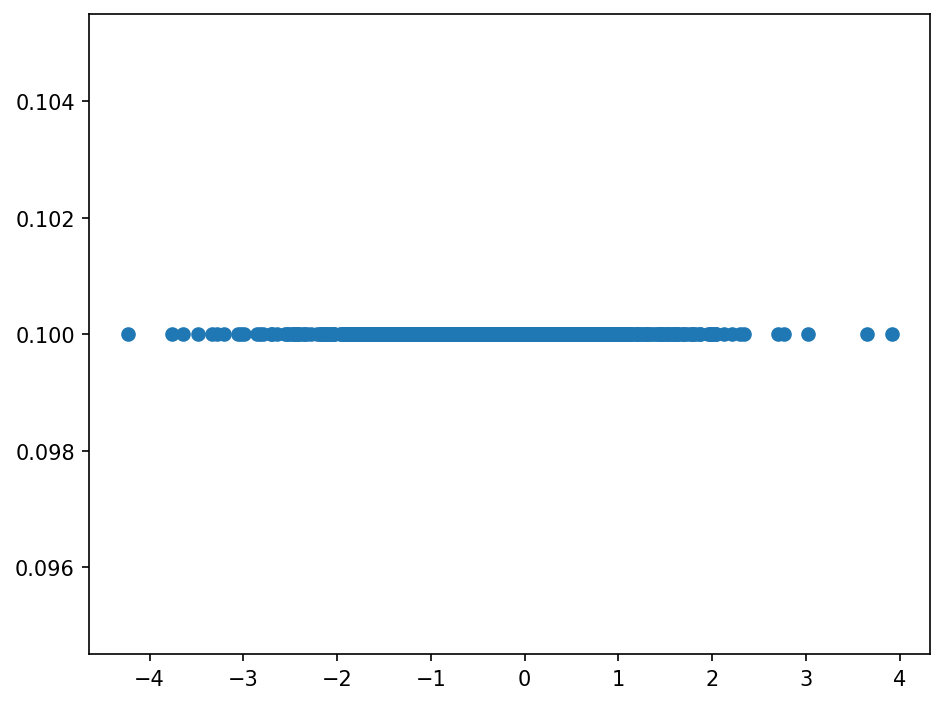

Alternatives 
- Bi-variate MASH like in the TRADE paper (https://www.nature.com/articles/s41588-025-02169-3#Sec1): not really an alternative, it allows to compare correlations even when the ceiling is pretty different 

How do we know if this tends to over-estimate similarities? 
- Show that you can have same log FC correlation with very different ceiling - a model could have high performance in logFC prediction task for high correlation on perturbations with large errors, another could do better on perturbations with low errors, but very close to theoretical ceiling.  

Solutions:
- distance from ceiling (percentage?), assuming the standard error in the predicted logFC is the same 
- should we consider the standard errors of the predicted log fold changes? 
- Is better prediction on perturbations with high reliability more desirable? Than on perturbations with lower reliability?

This matters especially in comparisons between cell types, where the noise levels are very different (entirely driven by base mean expression)